In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [2]:
## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，选择每个动作的概率
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  ## 返回该状态下，选择的动作的概率

In [3]:
## 策略梯度算法
## 智能体
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        ## 实例化智能体的大脑
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):            # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)       ## 拿到该状态下，每个动作的选择概率
        action_dist = torch.distributions.Categorical(probs)    ##   配置 好采样的概率
        action = action_dist.sample()        ## 对该状态下，所有的动作采样，采样的概率是probs
        return action.item()                 ## 返回依概率采样得到的动作

    ## 训练策略网络的，用一条序列来训练
    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
            
        G = 0      ##   初始化回报值 = 0
        self.optimizer.zero_grad()     ## 所有参数的梯度置0
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]   ##  拿到这一步的奖励
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)    ##  拿到这一步的状态
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)         ##  拿到这一步的动作
            log_prob = torch.log(self.policy_net(state).gather(1, action))          ## 算动作概率的log值 
            G = self.gamma * G + reward   ## 算这一步状态s的回报
            loss = -log_prob * G  # 每一步的损失函数             ##  算这一步的动作回报，并取相反数的
            loss.backward()  # 反向传播计算梯度 ## 梯度会累加的
        self.optimizer.step()  # 梯度下降 update 参数 ## 所以一个序列以后，网络 policy_net 的参数才会 update

In [ ]:
## 策略梯度算法
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        ## 实例化智能体的大脑
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):            # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)       ## 拿到该状态下，每个动作的选择概率
        action_dist = torch.distributions.Categorical(probs)    ##   配置 好采样的概率
        action = action_dist.sample()        ## 对该状态下，所有的动作采样，采样的概率是probs
        return action.item()                 ## 返回依概率采样得到的动作

    ## 训练策略网络的，用一条序列来训练
    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']
            
        G = 0      ##   初始化回报值 = 0
        self.optimizer.zero_grad()     ## 所有参数的梯度置0
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]   ##  拿到这一步的奖励
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)    ##  拿到这一步的状态
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)         ##  拿到这一步的动作
            ret = self.policy_net(state)
            kl = []
            for ik in range(len(ret)):
                kl.append(ret[ik, action[ik][0]])
            kl = torch.tensor(kl)
            # kl = ret.gather(1, action)

            log_prob = torch.log(kl)          ## 算动作概率的log值 
            G = self.gamma * G + reward   ## 算这一步状态s的回报
            loss = -log_prob * G  # 每一步的损失函数             ##  算这一步的动作回报，并取相反数的

            # log_prob.retain_grad()
            # kl.retain_grad()
            # kkk.retain_grad()
            # loss.backward()  # 反向传播计算梯度 ## 梯度会累加的
            # k = float(torch.flatten(log_prob.grad).numpy()[0])
            # k_ = float(torch.flatten(kl.grad).numpy()[0])
            # k__ = list(torch.flatten(kkk.grad).numpy())

            grad_log = -G
            grad_kl = grad_log * (1 / kl)
            grad_kkk = [0, grad_kl[0]] if action[0][0] > 0 else [grad_kl[0], 0]
            ret.backward(torch.tensor([grad_kkk]))
            # assert abs(grad_log - k) < 1e-6
            # assert abs(grad_kl - k_) < 1e-6
            # assert np.sum(abs(np.array(grad_kkk) - np.array(k__))) < 1e-6
        self.optimizer.step()  # 梯度下降 update 参数 ## 所以一个序列以后，网络 policy_net 的参数才会 update

In [6]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
_ = env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()
            if len(state)!=2*2:
                state = state[0]
            done = False
            ## 采样一条序列的
            while not done:
                action = agent.take_action(state)    ##  根据状态采取动作的
                ##  环境执行动作，并反馈下一个状态、动作的奖励、是否完成、步长太长的，info
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated | truncated       ## 终止或者步长太长，都会导致已经结束
                ## record该序列的 该时刻状态、该时刻动作、下一个状态、动作的奖励、是否完成的
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state    ## 下一个状态赋值到当前状态
                episode_return += reward  ##累加奖励的
            return_list.append(episode_return)
            agent.update(transition_dict)  ## 训练策略网络的，用一条序列来训练
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# Iteration 0: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s, episode=100,
# return=55.500]
# Iteration 1: 100%|██████████| 100/100 [00:08<00:00, 10.45it/s, episode=200,
# return=75.300]
# Iteration 2: 100%|██████████| 100/100 [00:16<00:00,  4.75it/s, episode=300,
# return=178.800]
# Iteration 3: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s, episode=400,
# return=164.600]
# Iteration 4: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, episode=500,
# return=156.500]
# Iteration 5: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s, episode=600,
# return=187.400]
# Iteration 6: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s, episode=700,
# return=194.500]
# Iteration 7: 100%|██████████| 100/100 [00:23<00:00,  4.24it/s, episode=800,
# return=200.000]
# Iteration 8: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s, episode=900,
# return=200.000]
# Iteration 9: 100%|██████████| 100/100 [00:22<00:00,  4.14it/s, episode=1000,
# return=186.100]

Iteration 9: 100%|█████████████████████████████████████| 100/100 [00:14<00:00,  6.93it/s, episode=1000, return=197.900]


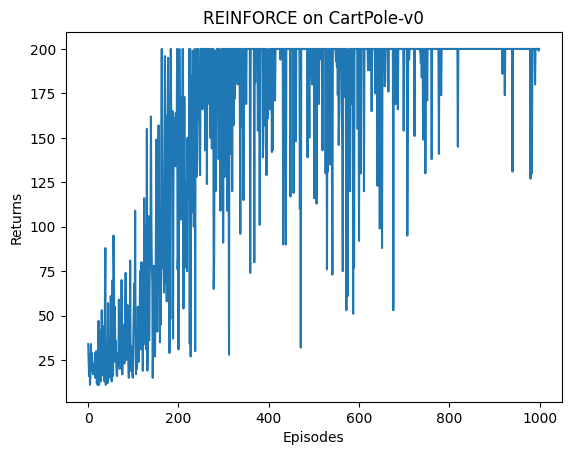

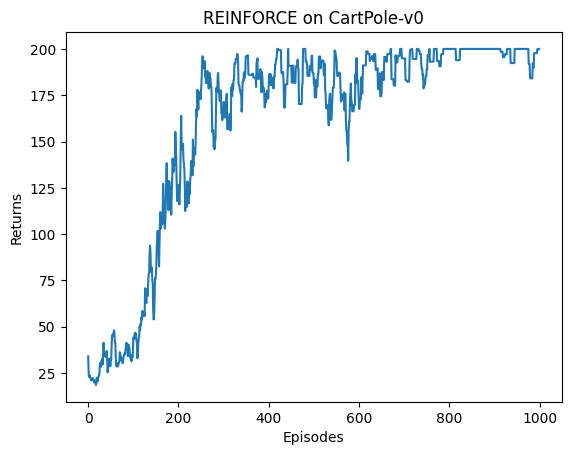

In [7]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()